<a href="https://colab.research.google.com/github/DAN-BIWOTT/Arasaka-TradingSystems/blob/main/Ensembled_SVR_%26_SFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install skl2onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.3/300.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.2 which is incompatible.
tensorflow 2

# Import Data Set

In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re

In [3]:
from google.colab import drive, files
drive.mount('/content/drive') # mount your google colab file

Mounted at /content/drive


In [4]:
filename_in_drive = "/content/drive/My Drive/Forex/Market Data USDJPY before 2025.01.01.csv"
data = pd.read_csv(filename_in_drive)
# Version Number
model_version = "2.1"
# Extract date from filename_in_drive
match = re.search(r'\b(\d{4}\.\d{2}\.\d{2})\b', filename_in_drive)
if match:
    extracted_date = match.group(1)
else:
    print("No date found in the filename.")
data.head(3)

,Time,Open,High,Low,Close,Volume
0,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
1,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0
2,1970.01.01 00:00:00,0.0,0.0,0.0,0.0,0


In [5]:
num_rows = len(data)
num_rows

99953

In [6]:
data = data[::-1]
# Reduce the dataset to the first 10,000 rows because
data = data.head(10000)
original_data = data.copy()

data.head(3)

,Time,Open,High,Low,Close,Volume
99952,2024.12.31 23:00:00,157.337,157.342,157.183,157.201,1053
99951,2024.12.31 22:00:00,157.304,157.372,157.286,157.337,2117
99950,2024.12.31 21:00:00,157.289,157.305,157.228,157.304,2105


In [7]:
num_rows = len(data)
num_rows

10000

In [8]:
data.tail()

,Time,Open,High,Low,Close,Volume
89957,2023.05.24 12:00:00,138.569,138.573,138.437,138.525,4801
89956,2023.05.24 11:00:00,138.638,138.682,138.491,138.570,6492
89955,2023.05.24 10:00:00,138.690,138.727,138.442,138.639,7699
89954,2023.05.24 09:00:00,138.281,138.690,138.243,138.690,6863
89953,2023.05.24 08:00:00,138.414,138.435,138.222,138.282,3968


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 99952 to 89953
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    10000 non-null  object 
 1   Open    10000 non-null  float64
 2   High    10000 non-null  float64
 3   Low     10000 non-null  float64
 4   Close   10000 non-null  float64
 5   Volume  10000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 468.9+ KB


In [10]:
#Define the forecast horizon
look_ahead = 1

In [11]:
#Calculate the median, which is the midpoint between the high and low prices.
data['Candlestick_Median'] = (data['High'] + data['Low']) / 2

data.head()

,Time,Open,High,Low,Close,Volume,Candlestick_Median
99952,2024.12.31 23:00:00,157.337,157.342,157.183,157.201,1053,157.2625
99951,2024.12.31 22:00:00,157.304,157.372,157.286,157.337,2117,157.3290
99950,2024.12.31 21:00:00,157.289,157.305,157.228,157.304,2105,157.2665
99949,2024.12.31 20:00:00,157.361,157.387,157.228,157.289,3662,157.3075
99948,2024.12.31 19:00:00,157.362,157.541,157.302,157.353,5904,157.4215


In [12]:
# Define features (X) and target (y)
X = data[['Candlestick_Median']]  # Features: Candlestick Median
y = data['Candlestick_Median'].shift(-1)
data = data.rename(columns={'Candlestick_Median': 'Future_Median'})
data['Price_Difference'] = data['High'] - data['Low']
data['Open_Close_Change_Pct'] = (data['Close'] - data['Open']) / data['Open'] * 100
data['High_Low_Change_Pct'] = (data['High'] - data['Low']) / data['Low'] * 100
data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean() # 20-period moving average of volume
data['Volume_Change_Pct'] = data['Volume'].pct_change() * 100 # Percentage change in volume

In [13]:
# Create lagged median prices
data['median_t-1'] = data['Future_Median'].shift(2)
data['median_t-2'] = data['Future_Median'].shift(3)

In [14]:
# Update features (X)
X = data[["Open", "High", "Low", "Close", "Price_Difference", "Open_Close_Change_Pct",
          "High_Low_Change_Pct", "Volume", "Volume_MA_20", "Volume_Change_Pct",
          "median_t-1", "median_t-2"]].copy()
y = data["Future_Median"]  # Target variable

In [15]:
# Removing NAN Values
X.dropna(inplace=True)
y = y[X.index]

 Ensemble an SVR and an SFN

In [16]:
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

scale

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}  # Example hyperparameter grid
grid_search = GridSearchCV(LinearSVR(max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_linear_svr_model = grid_search.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

# Define the hyperparameter grid for the SFN (MLPRegressor)
param_grid_sfn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Create GridSearchCV object for the SFN
grid_search_sfn = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42),
                               param_grid_sfn, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
grid_search_sfn.fit(X_train, y_train)

# Get the best SFN model
best_sfn_model = grid_search_sfn.best_estimator_

print("Best SFN Model:")
print(best_sfn_model)

Best SFN Model:
MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(50, 50),
             max_iter=1000, random_state=42)


In [21]:
ensemble_model = VotingRegressor(estimators=[('linear_svr', best_linear_svr_model), ('sfn', best_sfn_model)],
                                 weights=[0.7, 0.3])  # Example: 0.7 for LinearSVR, 0.3 for SFN
ensemble_model.fit(X_train, y_train)

VotingRegressor(estimators=[('linear_svr',
                             LinearSVR(C=1, epsilon=0.01, max_iter=10000)),
                            ('sfn',
                             MLPRegressor(activation='tanh', alpha=0.01,
                                          hidden_layer_sizes=(50, 50),
                                          max_iter=1000, random_state=42))],
                weights=[0.7, 0.3])

In [22]:
# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error of Ensemble: {mse}")

Mean Squared Error of Ensemble: 0.00036875662128053226


Graph the perfomance

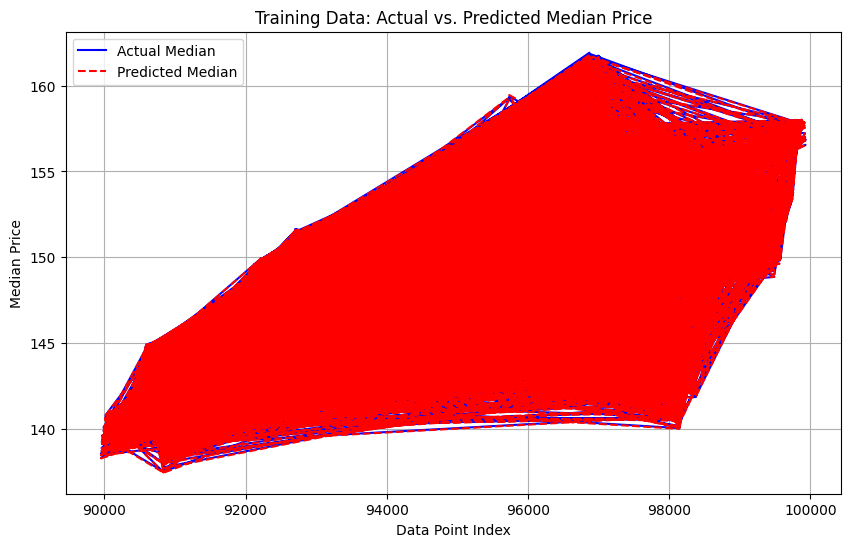

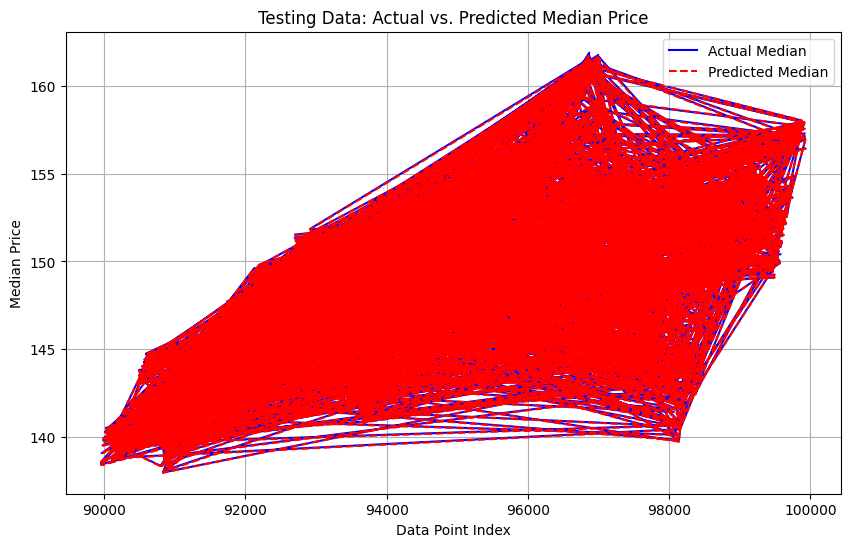

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Predictions (Same as before)
y_train_pred = ensemble_model.predict(X_train)
y_test_pred = ensemble_model.predict(X_test)

# 2. Training Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_train.index, y_train_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Training Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. Testing Data Performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Median', color='blue')  # Actual median in blue
plt.plot(y_test.index, y_test_pred, label='Predicted Median', color='red', linestyle='--')  # Predicted median in dashed red
plt.title('Testing Data: Actual vs. Predicted Median Price')
plt.xlabel('Data Point Index')
plt.ylabel('Median Price')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import json
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

# 1. Calculate Performance Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_explained_variance = explained_variance_score(y_train, y_train_pred)
test_explained_variance = explained_variance_score(y_test, y_test_pred)

# 2. Store Metrics in a Dictionary
performance_metrics = {
    "train_mse": train_mse,
    "test_mse": test_mse,
    "train_rmse": train_rmse,
    "test_rmse": test_rmse,
    "train_mae": train_mae,
    "test_mae": test_mae,
    "train_r2": train_r2,
    "test_r2": test_r2,
    "train_explained_variance": train_explained_variance,
    "test_explained_variance": test_explained_variance
}

# 3. Get Features and Model Name
features = list(X.columns)
model_name = f"{model_version}_Ensemble Model (Linear SVR + SFN)_{extracted_date}"  # Update model name

# 4. (Optional) Scaling Parameters - If you used scaling, include this part
scaling_parameters = {
    "mean": scaler.mean_.tolist(),
    "std_dev": scaler.scale_.tolist()
}

# 5. Create Log Data Dictionary
log_data = {
    "model_name": model_name,
    "features": features,
    "performance_metrics": performance_metrics,
    # "scaling_parameters": scaling_parameters  # Include if you have scaling parameters
}

# 6. Save to JSON File
# Assuming 'extracted_date' is defined earlier in your code
with open(f"{model_name}_log_{extracted_date}.json", "w") as f:
    json.dump(log_data, f, indent=4)

print(f"{model_version}_Model log saved to {model_name}_log_{extracted_date}.json")

2.1_Model log saved to 2.1_Ensemble Model (Linear SVR + SFN)_2025.01.01_log_2025.01.01.json


In [25]:
print("Scaling Mean:", ', '.join(map(str, scaler.mean_)))
print("Scaling Standard Deviation:", ', '.join(map(str, scaler.scale_)))

Scaling Mean: 149.07723647294588, 149.18885383266536, 148.95644013026052, 149.08042084168338, 0.23241370240480927, 0.002221430502238092, 0.15687871791400465, 4505.37249498998, 4505.936923847696, 19.39096950661133, 149.07396373997997, 149.07481719689378
Scaling Standard Deviation: 5.455916711265203, 5.444192343460877, 5.465966010324692, 5.4556889840172476, 0.2112365204047943, 0.12392667897669164, 0.14318926167926885, 3017.5794876363066, 1880.9825568694746, 123.06694919631848, 5.453224872235779, 5.451410828736534


ONNX file Generation

In [26]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx

In [27]:
initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features

In [28]:
# Convert weights to a NumPy array before converting to ONNX
ensemble_model.weights = np.array(ensemble_model.weights)

initial_type = [('input', FloatTensorType([None, X_test.shape[1]]))]  # Define input shape based on your features
onnx_model = convert_sklearn(ensemble_model, initial_types=initial_type)
with open(f"{model_version}_ensemble_model_{extracted_date}.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())